For a notebook extensions such as table of contents, please visit https://github.com/ipython-contrib/jupyter_contrib_nbextensions and follow install instructions

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Summary" data-toc-modified-id="Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></div><div class="lev1 toc-item"><a href="#Cagniard-de-Hoop-Method" data-toc-modified-id="Cagniard-de-Hoop-Method-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Cagniard de Hoop Method</a></div><div class="lev2 toc-item"><a href="#Generalized-Solution" data-toc-modified-id="Generalized-Solution-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Generalized Solution</a></div><div class="lev3 toc-item"><a href="#Time-functions" data-toc-modified-id="Time-functions-211"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Time functions</a></div><div class="lev3 toc-item"><a href="#P-plane-Path" data-toc-modified-id="P-plane-Path-212"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>P-plane Path</a></div><div class="lev3 toc-item"><a href="#Find-$dp/dt$" data-toc-modified-id="Find-$dp/dt$-213"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Find <span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-6-Frame" tabindex="0" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>d</mi><mi>p</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo>/</mo></mrow><mi>d</mi><mi>t</mi></math>" role="presentation" style="position: relative;"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-50" role="math" style="width: 2.595em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.132em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.715em 1002.13em 2.873em -999.998em); top: -2.544em; left: 0.002em;"><span class="mrow" id="MathJax-Span-51"><span class="mi" id="MathJax-Span-52" style="font-family: STIXMathJax_Main-italic;">d<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.049em;"></span></span><span class="mi" id="MathJax-Span-53" style="font-family: STIXMathJax_Main-italic;">p</span><span class="texatom" id="MathJax-Span-54"><span class="mrow" id="MathJax-Span-55"><span class="mo" id="MathJax-Span-56" style="font-family: STIXMathJax_Main;">/</span></span></span><span class="mi" id="MathJax-Span-57" style="font-family: STIXMathJax_Main-italic;">d<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.049em;"></span></span><span class="mi" id="MathJax-Span-58" style="font-family: STIXMathJax_Main-italic;">t<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.002em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.549em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.275em; border-left: 0px solid; width: 0px; height: 1.169em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>d</mi><mi>p</mi><mrow class="MJX-TeXAtom-ORD"><mo>/</mo></mrow><mi>d</mi><mi>t</mi></math></span></span><script type="math/tex" id="MathJax-Element-6">dp/dt</script></a></div><div class="lev3 toc-item"><a href="#SH-Functions" data-toc-modified-id="SH-Functions-214"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>SH Functions</a></div><div class="lev3 toc-item"><a href="#Potential-function" data-toc-modified-id="Potential-function-215"><span class="toc-item-num">2.1.5&nbsp;&nbsp;</span>Potential function</a></div><div class="lev2 toc-item"><a href="#Application:-Compute-synthetic-for-Alum-Rock" data-toc-modified-id="Application:-Compute-synthetic-for-Alum-Rock-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Application: Compute synthetic for Alum Rock</a></div><div class="lev3 toc-item"><a href="#Synthetic-Data" data-toc-modified-id="Synthetic-Data-221"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Synthetic Data</a></div><div class="lev3 toc-item"><a href="#Observed-Data" data-toc-modified-id="Observed-Data-222"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Observed Data</a></div><div class="lev1 toc-item"><a href="#Love-Wave-mode-summation-following-Haskell-(1951)" data-toc-modified-id="Love-Wave-mode-summation-following-Haskell-(1951)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Love Wave mode summation following Haskell (1951)</a></div><div class="lev2 toc-item"><a href="#Theory" data-toc-modified-id="Theory-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Theory</a></div><div class="lev2 toc-item"><a href="#Computation-process" data-toc-modified-id="Computation-process-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Computation process</a></div><div class="lev3 toc-item"><a href="#Plot" data-toc-modified-id="Plot-321"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Plot</a></div><div class="lev3 toc-item"><a href="#Plot" data-toc-modified-id="Plot-322"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Plot</a></div><div class="lev2 toc-item"><a href="#2-layer-analytic-dispersion" data-toc-modified-id="2-layer-analytic-dispersion-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>2-layer analytic dispersion</a></div><div class="lev1 toc-item"><a href="#Waveform-Monte-Carlo" data-toc-modified-id="Waveform-Monte-Carlo-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Waveform Monte Carlo</a></div>

# Summary

This notebook walks the user through the calculation of synthetic seismograms both via the Cagniard de Hoop integral method and l1 mode summmation method as outlined in Aki & Richards. It is worth noting here thought that various problems were encountered; some of which were never solved.

To Fix:    
 1) Unknown amplitude issue in Cagniard de Hoop synthetics     
    2) L1 calculation blows up at depth, though largely after the depths of interest

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from __future__ import print_function
from scipy.optimize import fsolve
import obspy
%matplotlib inline

# Cagniard de Hoop Method
We seek to calculate the response to a point source in a vertically heterogeneous medium by summing over geometric rays. The Cagniard de Hoop method is a manipulation of the elastic equations so that we do not need to perform any inverse transform integrations. Instead, our primary goal is the accurate calculation of the integration path through the complex p-plane for which time is real and increasing (C - figure below).

<img src=cdh_int_fig.png>

## Generalized Solution

### Time functions
For each ray, we must find the integration path (C - above figure) through the complex p-plane for which time is real and increasing (although we never need to complete the integral). To facilitate this, we define a time function for each geometric ray. A direct wave has the familiar formula $t = px + \eta z$, while more complicated waves have functions of the form $t = px + \eta_i z_i$. Since $\eta = \sqrt{B^{-2}-p^2}$, it wasn't obvious how to do a MATLAB-style element-wise caluculation over an array of p-points. Instead, individual functions that take one p-point and return one t-point are defined.

The time functions are labeled as upgoing [**u**] or downgoing [**d**] from the source followed by reflections [**R**] and transmissions [**T**] at each layer interface encountered. Each function calculates the time associated with a point in the complex p-plane. The inputs are a [p] value, the horizontal source-receiver distance [x], the depths of layer interfaces [z_array], and the velocities of the layers [B_array]. The velocity structure is assumed to take the form

z_array[0] --------------  
velocity: B_array[0]  
z_array[1] --------------  
velocity: B_array[1]  

        ...  

z_array[n] --------------  
velocity: B_array[n] (this is the half-space)

For three layers over a half-space with the source in the second layer, the first five rays of interest are the direct transmission, two reflected multiples, the simplest upgoing wave which traverses the third layer, and the simplest downgoing wave which traverses the third layer. Their time functions are defined:

In [2]:
def time_func_uT(p_point,x,z_array,B_array):
    return p_point*x + (z_array[0]-z_array[1])*np.sqrt(1/B_array[1]**2-p_point**2) + z_array[1]*np.sqrt(1/B_array[0]**2-p_point**2)
def time_func_uTRR(p_point,x,z_array,B_array):
    return p_point*x + (z_array[0]-z_array[1])*np.sqrt(1/B_array[1]**2-p_point**2) + 3*z_array[1]*np.sqrt(1/B_array[0]**2-p_point**2)
def time_func_uTRRRR(p_point,x,z_array,B_array):
    return p_point*x + (z_array[0]-z_array[1])*np.sqrt(1/B_array[1]**2-p_point**2) + 5*z_array[1]*np.sqrt(1/B_array[0]**2-p_point**2)
def time_func_dRT(p_point,x,z_array,B_array):
    return p_point*x + (2*z_array[2]-z_array[0]-z_array[1])*np.sqrt(1/B_array[1]**2-p_point**2) + z_array[1]*np.sqrt(1/B_array[0]**2-p_point**2)
def time_func_dTRTT(p_point,x,z_array,B_array):
    return p_point*x + 2*(z_array[3]-z_array[2])*np.sqrt(1/B_array[2]**2-p_point**2) + 2*(z_array[2]-z_array[1])*np.sqrt(1/B_array[1]**2-p_point**2) + z_array[1]*np.sqrt(1/B_array[0]**2-p_point**2)


### P-plane Path
To find the function $t(p)$ for each ray, we start from the known location $p=0$ and use a radial search. The function goes out to infinite time, so we must choose a stop condition. Here, a maximum time is used. For the part of the path on the negative real p-axis, going back to where t=0, we are able to use a nonlinear solver. The radial search find points that are unevenly spaced in time, so we use an interpolator to find the desired spacing. The path-finding function takes inputs for the horizontal distance [x], the depths of layer interfaces [z_array], the layer velocities [B_array], the time function for the ray of interest [time_func], the maximum time to calculate [t_max], and the desired time spacing [dt].

In [3]:
def path_search_radial(x, z_array, B_array, time_func, t_max, dt):
    p = [0*1j] #start at p=0
    t = [time_func(p[0],x,z_array,B_array).real] #find the first t value
    
    while t[-1] < t_max:
        # split the p-point into real and complex coordinates
        w0 = p[-1].real
        y0 = p[-1].imag
        coords = []
        # define the search space for the next point
        for theta in range(0,90):
            th = theta*np.pi/180
            w = w0 + np.cos(th)*.0005
            y = y0 + np.sin(th)*.0005
            coords.append((w,y))
        # calculate t values over the search space
        tvals = [time_func(complex(*coord),x,z_array,B_array) for coord in coords]
        # find the maximum real time point
        t_ind = np.argmax([tv.real for tv in tvals])
        t = np.append(t,tvals[t_ind].real)
        p = np.append(p,complex(*coords[t_ind]))
        
        # add p<0 section, where p is known to be real and negative
        t_stub = np.arange(0,t[0],dt) #solve for p at each of these points in t
        def zero_func(p_in,t_in):
            make_zero = time_func(p_in,x,z_array,B_array) - t_in #t_in fixed, goal is to find p
            return make_zero
        p_stub = np.array([])
        for t_pt in t_stub:
            p_stub = np.append(p_stub,fsolve(zero_func,0,args=(t_pt)))
        t = np.concatenate((t_stub,t))
        p = np.concatenate((p_stub,p))
        
        # interpolate full function to dt spacing
        f=interp1d(t,p)
        ti=np.arange(0,np.floor(t[-1]),dt)
        pi = f(ti)
    
    return ti, pi

### Find $dp/dt$
For each $t(p)$ path we also need to find the function $dp/dt$. The inputs to get $dp/dt$ are the path solution points [p_solution] and the required spacing in time [dt].

In [4]:
def get_dpdt(p_solution,dt):
    dpdt = np.diff(p_solution)/dt
    return dpdt

### SH Functions
Next we process each ray to find ${\rm Im}\left (\frac{\sqrt p}{\eta} SH_j(p) \Pi(p) p \frac{dp}{dt}\right )$, where $SH_j$ are the radiation patterns and $\Pi$ is the product of reflection and transmission coefficients. Note that SH1 and SH2 are equivalent to tds and tss used in EPS 207.

$SH_1 = 1/\beta^2$ and $SH_2 = \frac{\varepsilon}{\beta^2}\frac{\eta}{p}$ where $\varepsilon$ is +1 for upgoing and -1 for downgoing rays. Since these are source radiation functions, we use the parameters of the source layer (possibly a bad assumption).

For confusion's sake, we've labeled the output of this full expression SH1 and SH2. We define functions to apply this expression to each ray with the inputs from the path solution [t] and [p], the velocity structure [B] and the density structure [rh].

In [5]:
def SH_uT(t,p,B,rh,dt):
    dpdt = get_dpdt(p,dt) #p is interpolated p
    mu = (B*1.e05)**2*rh
    Tr = 2*mu[1]*np.sqrt(1/B[1]**2-p[:-1]**2
                        )/(mu[0]*np.sqrt(1/B[0]**2-p[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-p[:-1]**2))
    SH1 = np.imag(np.sqrt(p[:-1])*Tr*p[:-1]*dpdt/(np.sqrt(1/B[1]**2-p[:-1]**2)*B[1]**2))
    SH2 = np.imag(np.sqrt(p[:-1])*Tr*dpdt/B[1]**2)
    return SH1,SH2

In [6]:
def SH_uTRR(t,p,B,rh,dt):
    dpdt = get_dpdt(p,dt) #p is interpolated p
    mu = (B*1.e05)**2*rh
    Tr = 2*mu[1]*np.sqrt(1/B[1]**2-p[:-1]**2
                        )/(mu[0]*np.sqrt(1/B[0]**2-p[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-p[:-1]**2))
    Re = (mu[0]*np.sqrt(1/B[0]**2-p[:-1]**2)-mu[1]*np.sqrt(1/B[1]**2-p[:-1]**2)
         )/(mu[0]*np.sqrt(1/B[0]**2-p[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-p[:-1]**2))
    SH1 = np.imag(np.sqrt(p[:-1])*Tr*Re*p[:-1]*dpdt/(np.sqrt(1/B[1]**2-p[:-1]**2)*B[1]**2))
    SH2 = np.imag(np.sqrt(p[:-1])*Tr*Re*dpdt/B[1]**2)
    return SH1,SH2

In [7]:
def SH_uTRRRR(t,p,B,rh,dt):
    dpdt = get_dpdt(p,dt) #p is interpolated p
    mu = (B*1.e05)**2*rh
    Tr = 2*mu[1]*np.sqrt(1/B[1]**2-p[:-1]**2
                        )/(mu[0]*np.sqrt(1/B[0]**2-p[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-p[:-1]**2))
    Re = (mu[0]*np.sqrt(1/B[0]**2-p[:-1]**2)-mu[1]*np.sqrt(1/B[1]**2-p[:-1]**2)
         )/(mu[0]*np.sqrt(1/B[0]**2-p[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-p[:-1]**2))
    SH1 = np.imag(np.sqrt(p[:-1])*Tr*Re*Re*p[:-1]*dpdt/(np.sqrt(1/B[1]**2-p[:-1]**2)*B[1]**2))
    SH2 = np.imag(np.sqrt(p[:-1])*Tr*Re*Re*dpdt/B[1]**2)
    return SH1,SH2

In [8]:
def SH_dRT(t,p,B,rh,dt):
    dpdt = get_dpdt(p,dt) #p is interpolated p
    mu = (B*1.e05)**2*rh
    Tr = 2*mu[1]*np.sqrt(1/B[1]**2-p[:-1]**2
                        )/(mu[0]*np.sqrt(1/B[0]**2-p[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-p[:-1]**2))
    Re = (mu[1]*np.sqrt(1/B[1]**2-p[:-1]**2)-mu[2]*np.sqrt(1/B[2]**2-p[:-1]**2)
         )/(mu[1]*np.sqrt(1/B[1]**2-p[:-1]**2)+mu[2]*np.sqrt(1/B[2]**2-p[:-1]**2))
    SH1 = np.imag(np.sqrt(p[:-1])*Tr*Re*p[:-1]*dpdt/(np.sqrt(1/B[1]**2-p[:-1]**2)*B[1]**2))
    SH2 = np.imag(-1*np.sqrt(p[:-1])*Tr*Re*dpdt/B[1]**2)
    return SH1,SH2

In [9]:
def SH_dTRTT(t,p,B,rh,dt):
    dpdt = get_dpdt(p,dt) #p is interpolated p
    mu = (B*1.e05)**2*rh
    Tr_10 = 2*mu[1]*np.sqrt(1/B[1]**2-p[:-1]**2
                        )/(mu[0]*np.sqrt(1/B[0]**2-p[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-p[:-1]**2))
    Tr_12 = 2*mu[1]*np.sqrt(1/B[1]**2-p[:-1]**2
                        )/(mu[2]*np.sqrt(1/B[2]**2-p[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-p[:-1]**2))
    Tr_21 = 2*mu[2]*np.sqrt(1/B[2]**2-p[:-1]**2
                        )/(mu[2]*np.sqrt(1/B[2]**2-p[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-p[:-1]**2))
    Re = (mu[2]*np.sqrt(1/B[2]**2-p[:-1]**2)-mu[3]*np.sqrt(1/B[3]**2-p[:-1]**2)
         )/(mu[2]*np.sqrt(1/B[2]**2-p[:-1]**2)+mu[3]*np.sqrt(1/B[3]**2-p[:-1]**2))
    SH1 = np.imag(np.sqrt(p[:-1])*Tr_12*Re*Tr_21*Tr_10*p[:-1]*dpdt/(np.sqrt(1/B[1]**2-p[:-1]**2)*B[1]**2))
    SH2 = np.imag(-1*np.sqrt(p[:-1])*Tr_12*Re*Tr_21*Tr_10*dpdt/B[1]**2)
    return SH1,SH2

### Potential function
We finally reach the potential function that allows us to calculate a synthetic seismogram with radiation pattern and source time function (Helmberger Eqn. 2.33). The SH solution on a free boundary is defined as 

$$V = \frac{M_0}{4\pi\rho_0}\frac{d}{dt}[\dot{D(t)} * \Sigma^{2}_{j=1} A_{j+3}(\theta,\lambda,\delta)V_j(t)]$$ 

where 

$$V_j(t) = \sqrt{2/r}\frac{1}{\pi}[\frac{1}{\sqrt{t}}*SH_j]$$.

$M_0$ is the scalar seismic moment (units of dyne-cm...default is $10^{20}$ dyne-cm); $\dot{D(t)}$ is the source time function (e.g., triangle; Brune); $A_{j+3}(\theta,\lambda,\delta)$ are the coefficients describing the relative weight of the transverse vertical strike-slip (tss) and dip-slip (tds) fundamental-faults, which depend on fauilt dip ($\delta$), rake ($\lambda$), and angle between station and strike of fault ($\theta$).

In [10]:
def Vt(t,r,SH):
    A1=np.pi*np.pi/16;
    sdt=2.0/np.sqrt(dt);
    a=0;
    m = len(t)
    rt = np.zeros((m,1))[:,0]
    for I in range(0,m):
         b=np.sqrt((I) + A1)
         rt[I]=sdt * (b - a)
         a = b
    return (np.sqrt(2/(r))/np.pi)*np.convolve(rt,SH)

In [11]:
def scaleMoment(M0,x,beta,rh):
    return M0*2/np.pi*np.sqrt(2/x)*1/(beta**2)*1/(4*np.pi*rh)

In [12]:
def radiationPattern(azimuth,strike,dip,rake):
    theta=azimuth-strike;
    theta=theta*np.pi/180;
    rake=rake*np.pi/180;
    dip=dip*np.pi/180;
    A4=np.cos(2*theta)*np.cos(rake)*np.sin(dip)-0.5*np.sin(2*theta)*np.sin(rake)*np.sin(2*dip);
    A5=-1*np.sin(theta)*np.cos(rake)*np.cos(dip)-np.cos(theta)*np.sin(rake)*np.cos(2*dip);
    return A4,A5

In [13]:
def synth_sourcetime(A4,A5,M0,Vt_SH1,Vt_SH2,risetime,dt,rh):
    def synth():
        s = np.diff((A4*Vt_SH1 + A5*Vt_SH2))/dt
        return M0*s
    def makeDdot():
        time=np.arange(0,risetime*3,dt)
        sourceTimeFn=time*np.e**(-time/(risetime/4.0))
        return sourceTimeFn/np.trapz(sourceTimeFn)

    return np.convolve(makeDdot(),synth())

## Application: Compute synthetic for Alum Rock
With these components, we're able to compute a synthetic seismogram for a velocity model.

Define geomoetry for solving:

In [14]:
x = 80.05 #Station distance
z_arr = np.array([8,5,16,35]) #Depth array
B_arr = np.array([2.2,3.34,3.97,4.0]) #Velocity array
rho = np.array([2.4,2.67,2.8,3.3]) #Density array
dt = .01
azimuth=321.6;
strike=318;
dip=83;
rake=-176;
M0=9.20e2;
risetime=.5;

Pick max time:

In [15]:
tmax = 120 #seconds

Get individual ray paths in the complex p-plane:

In [16]:
t_uT,p_uT = path_search_radial(x, z_arr, B_arr, time_func_uT, tmax, dt)
t_uTRR,p_uTRR = path_search_radial(x, z_arr, B_arr, time_func_uTRR, tmax, dt)
t_uTRRRR,p_uTRRRR = path_search_radial(x, z_arr, B_arr, time_func_uTRRRR, tmax, dt)
t_dRT,p_dRT = path_search_radial(x, z_arr, B_arr, time_func_dRT, tmax, dt)
t_dTRTT,p_dTRTT = path_search_radial(x, z_arr, B_arr, time_func_dTRTT, tmax, dt)

Plot p-plane ray paths:

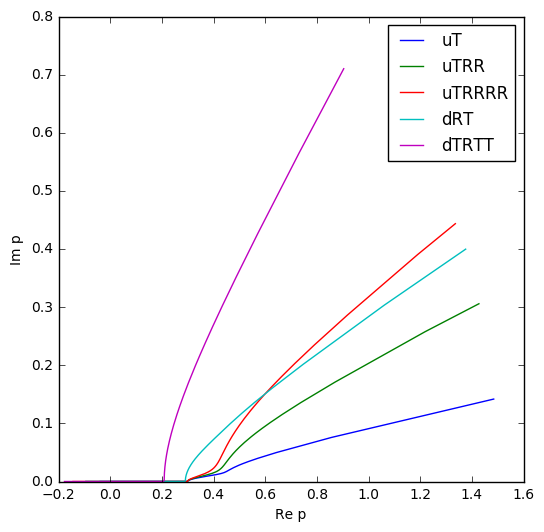

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (6,6))
ax.plot(p_uT.real,p_uT.imag,p_uTRR.real,p_uTRR.imag,p_uTRRRR.real,p_uTRRRR.imag,p_dRT.real,p_dRT.imag,p_dTRTT.real,p_dTRTT.imag)
ax.set_xlabel("Re p")
ax.set_ylabel("Im p")
ax.legend(("uT","uTRR","uTRRRR","dRT","dTRTT"))

Sum imaginary parts for SH1 and SH2:

In [18]:
SH_sum = np.array(SH_uT(t_uT,p_uT,B_arr,rho,dt))
SH_sum += np.array(SH_uTRR(t_uTRR,p_uTRR,B_arr,rho,dt))
SH_sum += np.array(SH_uTRRRR(t_uTRRRR,p_uTRRRR,B_arr,rho,dt))
SH_sum += np.array(SH_dRT(t_dRT,p_dRT,B_arr,rho,dt))
SH_sum += np.array(SH_dTRTT(t_dTRTT,p_dTRTT,B_arr,rho,dt))

Apply radiation pattern and source time function:

In [19]:
t = np.arange(dt,tmax,dt)
A4,A5 = radiationPattern(azimuth,strike,dip,rake)
M0=scaleMoment(M0,x,B_arr[1],rho[1])
uSH = synth_sourcetime(A4,A5,M0,Vt(t,x,SH_sum[0,:]),Vt(t,x,SH_sum[1,:]),risetime,dt,rho) #njl

### Synthetic Data

Note the differing aplitude and $y = 0$ reflection relative to the observed data below.

(0.0, 8000)

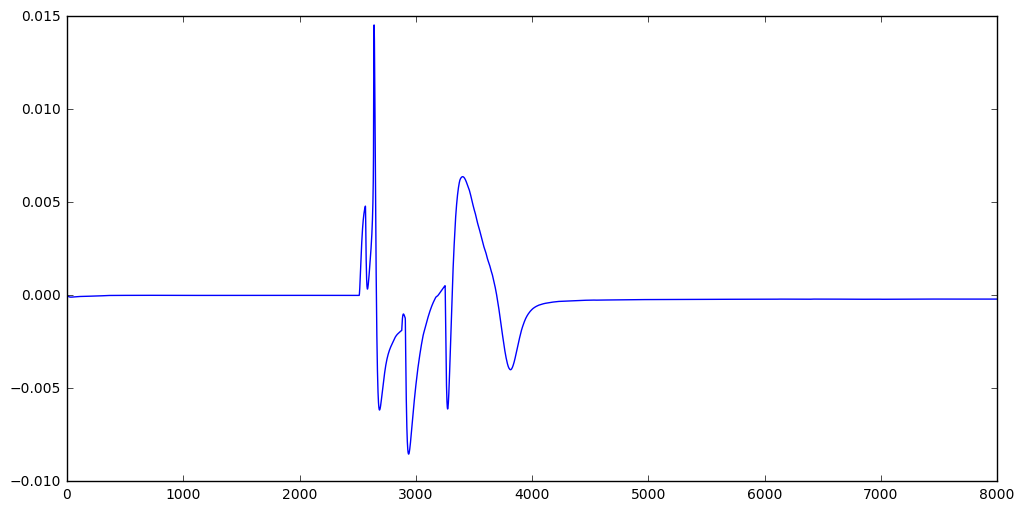

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (12,6))
ax.plot(uSH)
ax.set_xlim(right=8000)

### Observed Data

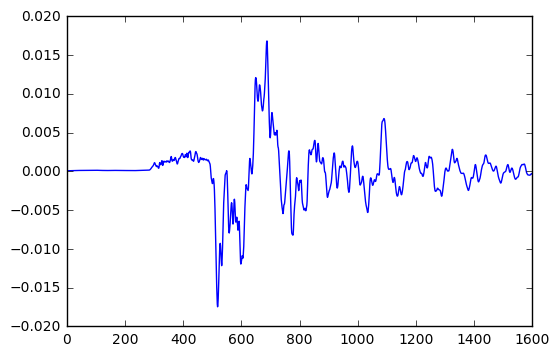

In [21]:
d=obspy.read('alumdata')
plt.plot(d[0])

# Love Wave mode summation following Haskell (1951)
Model has $n$ layers, where the $n$th is the lower half-space and the zero-th is the free half-space. The layer boundaries $0$ to $n-1$ are above the $n$ layers.
## Theory
Displacement and stress within a homogeneous layer:
$$v = \exp[i(pt-kx)][v'\exp(-ikr_\beta z)+v''\exp(ikr_\beta z)]$$
$$Y_z = \mu\partial v/\partial z = ik\mu r_\beta \exp[i(pt-kx)][-v'\exp(-ikr_\beta z)+v''\exp(ikr_\beta z)]$$
Note that $p$ is the angular frequency, usually $\omega$.

Place the $z$ origin at the $(m-1)$th interface so that:
$$(\dot v/c)_{m-1} = ik(v_m'+v_m'')$$
$$(Y_z)_{m-1} = ik\mu_m r_{\beta m}(v_m''-v_m')$$

and at the $m$th interface (next one down, $z = d_m$):
$$(\dot v/c)_{m} = (v_m'+v_m'')ik\cos Q_m - (v_m''-v_m')\
sin Q_m$$
$$(Y_z)_{m} = -(v_m'-v_m'')k\mu_m r_{\beta m}\sin Q_m + (v_m''-v_m')k\mu_m r_{\beta m}\cos Q_m$$
where $Q = kr_{\beta m}d_m$

Eliminate the constants $v_m'$ and $v_m''$ to find:
$$(\dot v_m/c)_m = (\dot v/c)_{m-1}\cos Q_m + (Y_z)_{m-1}\mu_m^{-1}r_{\beta m}^{-1}i\sin Q_m$$
$$(Y_z)_m = (\dot v/c)_{m-1}i\mu_m r_{\beta m}\sin Q_m + (Y_z)_{m-1}\cos Q_m$$

So the propagator matrix (with a time derivative so that $l_1$ is replaced by $l_1 ik/c$) is:
$$a_m = \begin{bmatrix} \cos Q_m & i\mu_m^{-1}r_{\beta m}^{-1}\sin Q_m \\ i\mu_mr_{\beta m}\sin Q_m & \cos Q_m \end{bmatrix}$$

The combined propagation through all layers $A = a_{n-1}a_{n-2}...a_1$ leads to the equations at the lowest interface:
$$(\dot v/c)_{n-1} = A_{11}(\dot v/c)_0 + A_{12}(Y_z)_0$$
$$(Y_z)_{n-1} = A_{21}(\dot v/c)_0 + A_{22}(Y_z)_0$$

The coefficients in the lower half space are:
$$v_n'+v_n'' = A_{11}(ik)^{-1}(\dot v/c)_0 + A_{12}(ik)^{-1}(Y_z)_0$$
$$v_n''-v_n' = A_{21}(ik\mu_n r_{\beta n})^{-1}(\dot v/c)_0 + A_{22}(ik\mu_n r_{\beta n})^{-1}(Y_z)_0$$

The boundary conditions call for $(Y_z)_0 = 0$ and $v_n'' = 0$, so the dispersion relation is:
$$A_{21} = -\mu_n r_{\beta n}A_{11}$$

## Computation process
1. Find k(c) over the range of acceptable phase velocities (vs_min to vs_max)
2. Find $(\dot v/c)\cdot c/ik = l_1$ throughout the model at a range of frequencies
3. Plot $l_1$ and check boundary conditions and bounded-ness

Two layers over half-space (non-dimensionalized):

In [22]:
dm = np.array([4, 21, 100])*100000
B = np.array([2.4, 3.5, 4.5])*100000
rho = np.array([2.0, 2.67, 3.3])
mu = (B**2)*rho

Bounds on phase velocity:

In [23]:
cmin = min(B)
cmax = max(B)
c = np.linspace(cmin,cmax,100)

In [28]:
k_test = np.linspace(0,3e-6,1e5)

r_b is a function of c and layer velocity

In [29]:
r_b = np.zeros((len(c),len(B)),dtype=complex)
for ci in range(len(c)):
    for bi in range(len(B)):
        if c[ci]>B[bi]:
            r_b[ci,bi] = np.sqrt((c[ci]/B[bi])**2-1)
        else:
            r_b[ci,bi] = -1j*np.sqrt(1-(c[ci]/B[bi])**2)

Make A matrix as a function of k and c (index):

In [30]:
def A_mat(k,ci):
    # TODO solve case for ci=0 (currently sets a[0,1]=0)
    #calculate each a_m matrix and multiply
    A = np.ones((2,2),dtype=complex)
    a_m = np.zeros((2,2),dtype=complex)
    for m in [1]:
        Q_m = k*r_b[ci,m]*dm[m]
        if Q_m == np.real(Q_m):
            a_m[0,0] = np.cos(Q_m)
            a_m[1,1] = np.cos(Q_m)
            a_m[0,1] = 1j*np.sin(Q_m)/(mu[m]*r_b[ci,m])
            a_m[1,0] = 1j*mu[m]*r_b[ci,m]*np.sin(Q_m)
        else:
            a_m[0,0] = np.cosh(Q_m)
            a_m[1,1] = np.cosh(Q_m)
            a_m[0,1] = 1j*np.sinh(Q_m)/(mu[m]*r_b[ci,m])
            a_m[1,0] = 1j*mu[m]*r_b[ci,m]*np.sinh(Q_m)
        if ci == len(c)-1:
            a_m[0,1] = 0
        A = np.multiply(a_m,A)
    return A

check dispersion relation:

In [31]:
ci_test = 0
check_zero = np.zeros(len(k_test),dtype=complex)
for ki in range(len(k_test)):
    A = A_mat(k_test[ki],ci_test)
    check_zero[ki] = A[1,0]/(mu[-1]*r_b[ci_test,-1]) + A[0,0]
print(A)

[[-0.12646333 -0.00000000e+00j  0.00000000 -4.16675001e-12j]
 [ 0.00000000 +2.36156962e+11j -0.12646333 -0.00000000e+00j]]


### Plot 

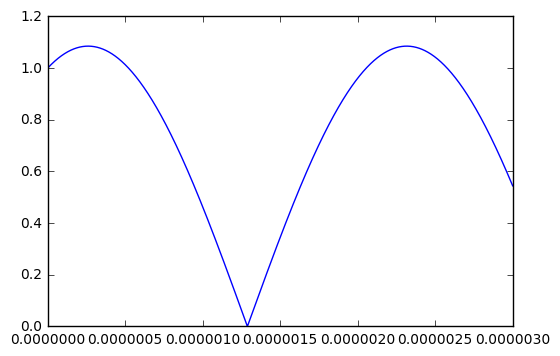

In [32]:
plt.plot(k_test,np.abs(check_zero))

In [35]:
k_test = np.linspace(1e-6,1.5e-6,1e5)
k_now = k_of_c[54]
k_test = np.linspace(.98*k_now,3*k_now,1e5)
for ci_test in range(55,65):
    check_zero = np.zeros(len(k_test),dtype=complex)
    for ki in range(len(k_test)):
        A = A_mat(k_test[ki],ci_test)
        check_zero[ki] = A[1,0]/(mu[-1]*r_b[ci_test,-1]) + A[0,0]
    k_now = k_test[np.argmin(abs(check_zero))]
    k_of_c2[ci_test] = k_now
    if ci_test<40:
        k_test = np.linspace(.95*k_now,1.5*k_now,1e5)
    else:
        k_test = np.linspace(.95*k_now,3.5*k_now,1e5)

NameError: name 'k_of_c' is not defined

### Plot

In [34]:
n=99
plt.plot(k_of_c2[:n],c[:n])

NameError: name 'k_of_c2' is not defined

## 2-layer analytic dispersion
Haskell (1951):
$$\tan Q_1 = -i(\mu_2 r_{\beta 2}/\mu_1 r_{\beta 1})$$
EPS 130 (probably also Modern Global Seismology):
$$\tan(\frac{2\pi}{T}H\sqrt{\beta_1^{-2}-c^{-2}}) = \frac{\mu_2}{\mu_1}\frac{\sqrt{c^{-2}-\beta_2^{-2}}}{\sqrt{\beta_1^{-2}-c^{-2}}}$$

See plots and note that Haskell matches more familiar EPS130 relation but negative!

In [ ]:
# One layer over half-space
dm = np.array([40, 100])*10000
B = np.array([2.4, 3.5])*10000
rho = np.array([2.0, 2.67])
mu = (B**2)*rho

In [ ]:
# 130 equation for dispersion
c_range = np.linspace(B[0],B[1],(B[1]-B[0])/10)
T_analytic = np.zeros(c_range.shape)
for c_ind in range(len(c_range)):
    c = c_range[c_ind]
    T_analytic[c_ind] = 2*np.pi*dm[0]*np.sqrt(B[0]**-2-c**-2)/np.arctan(np.sqrt(c**-2-B[1]**-2)*mu[1]/(np.sqrt(B[0]**-2-c**-2)*mu[0]))
#     print T_analytic[c_ind]
omega_a = 2*np.pi/T_analytic
k_a = omega_a/c_range

In [ ]:
#haskell analytic relation TODO fix r_b calculation for this bit
k_ha = np.arctan(1j*mu[1]*r_b[:,1]/(mu[0]*r_b[:,0]))/(r_b[:,0]*dm[0])
T_ha = 2*np.pi/(c*k_ha)
plt.plot(T_ha,c)

In [ ]:
plt.plot(T_analytic,c_range*10)
plt.plot(T_ha,c)

# Waveform Monte Carlo

A monte carlo method in which one plugs in an equation of the form: waveform_vector=F(layers) waveform_vector=F(layers)
where: layers is a class containing: layers.list - a list of layers layers.layerx - classes equal to the number of layers 0 < x < n+1 layers.layerx.den - the density of layer x layers.layerx.vel - the velocity of layer x layers.layerx.top - the depth of the upper boundary of layer x


In [ ]:
from cdh_mc import Model

Define a model space to Monte Carlo search within:

In [ ]:
params_dict = { 'min_layers':3, 'max_layers':3,  'min_rho':1, 'max_rho':3, 'min_vel':1, 'max_vel':3, \
              'min_depth':0, 'max_depth':300,} # units: N/A; g/cc; km/s; km

number_of_iterations = 100

Generalized implementation for finding the best model:

In [ ]:
misfit_vector = []

for iteration in np.arange(number_of_iterations):
    current_model = Model(params_dict) # generate random model
    current_misfit = calc_misfit(data, synthetic) # calculate the misfit
    
    if current_misfit < min(misfit_vector):
        best_model = current_model
    
    misfit_vector.append(current_misfit)